# 분석 목표
고객의 중분류 별로 선호하는 ETF를 확인하고, 그 ETF들의 특성을 나누어서 각 군집별로 추천하려고 합니다.

In [1]:
# 필요 library 설치
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

In [2]:
import os #데이터 불러올 시 데이터 경로를 맞추기 위함

# 데이터 위치를 설정하는 코드는 여러 번 불러오면 작업 디렉토리가 없는 이슈가 발생.
# 파일 시작 시 한 번만 작동

# 현재 작업 디렉토리 가져오기
current_directory = os.getcwd()
print("현재 디렉토리:", current_directory)

# 3개 위의 폴더 찾기
three_levels_up = os.path.dirname(os.path.dirname(os.path.dirname(current_directory)))
print("3개 위의 디렉토리:", three_levels_up)

# 데이터가 담긴 폴더로 이동
data_path = os.path.join(three_levels_up,'ETF_data')

# 현재 작업 디렉토리 확인
print("현재 작업 디렉토리:", os.getcwd())

# 새로운 디렉토리로 변경
os.chdir(data_path)

# 데이터가 담긴 파일을 작업 디렉토리로 설정
print("변경된 작업 디렉토리:", os.getcwd())

현재 디렉토리: c:\Users\erich\Desktop\HYU\DSHY\DSHY\EDA 실습\농협 공모전
3개 위의 디렉토리: c:\Users\erich\Desktop\HYU\DSHY
현재 작업 디렉토리: c:\Users\erich\Desktop\HYU\DSHY\DSHY\EDA 실습\농협 공모전
변경된 작업 디렉토리: c:\Users\erich\Desktop\HYU\DSHY\ETF_data


In [3]:
# 데이터 불러오기
## 파일 명을 알기 쉽게 정리
해외종목정보 = pd.read_csv("NH_CONTEST_NW_FC_STK_IEM_IFO.csv", encoding="EUC-KR", skipinitialspace=True)
종목일자별시세 = pd.read_csv("NH_CONTEST_STK_DT_QUT.csv", encoding="EUC-KR", skipinitialspace=True)
주식일별정보 = pd.read_csv("NH_CONTEST_NHDATA_STK_DD_IFO.csv", encoding="EUC-KR", skipinitialspace=True)
매수매도계좌정보 = pd.read_csv("NH_CONTEST_NHDATA_IFW_OFW_IFO.csv", encoding="EUC-KR", skipinitialspace=True)
고객보유정보 = pd.read_csv("NH_CONTEST_NHDATA_CUS_TP_IFO.csv", encoding="EUC-KR", skipinitialspace=True)
ETF구성종목정보 = pd.read_csv("NH_CONTEST_DATA_ETF_HOLDINGS.csv", encoding="EUC-KR", skipinitialspace=True)
ETF배당내역 = pd.read_csv("NH_CONTEST_DATA_HISTORICAL_DIVIDEND.csv", encoding="EUC-KR", skipinitialspace=True)
ETF점수정보 = pd.read_csv("NH_CONTEST_ETF_SOR_IFO.csv", encoding="EUC-KR", skipinitialspace=True)

data_name = ["해외종목정보", "종목일자별시세", "주식일별정보", "매수매도계좌정보", "고객보유정보", "ETF구성종목정보", "ETF배당내역", "ETF점수정보"]

## 각 파일 내 변수명 변경 + 공백제거
해외종목정보.columns = ["티커종목코드", "외화증권한글명", "외화증권영문명", "주식/ETF구분코드",
                   "상장주식총수량", "외화시장구분코드", "회사주소", "웹주소", "업종분류명",
                   "CEO명", "영문사업개요내용", "섹터분류명", "산업명", "시가총액"]
해외종목정보 = 해외종목정보.map(lambda x: x.strip() if isinstance(x, str) else x)

종목일자별시세.columns = ["거래일자", "티커종목코드", "종목시가", "종목고가", "종목저가",
                   "종목종가", "전일대비증감가격", "전일대비증감율", "누적거래수량",
                   "거래대금", "매도체결합계수량", "매수체결합계수량", "환율"]
종목일자별시세 = 종목일자별시세.map(lambda x: x.strip() if isinstance(x, str) else x)

주식일별정보.columns = ["거래일자", "티커종목코드", "총보유계좌수", "총보유수량",
                   "당사평균보유수량", "당사평균보유비중비율", "당사평균평가손익",
                   "당사평균매입단가", "당사평균수익율", "당사평균보유기간일수",
                   "분포상위10퍼센트수치", "분포상위30퍼센트수치", "분포상위50퍼센트수치",
                   "분포상위70퍼센트수치", "분포상위90퍼센트수치", "기준종가", "손실투자자비율",
                   "수익투자자비율", "신규매수계좌수", "전량매도계좌수", "종목조회건수",
                   "관심종목등록건수"]
주식일별정보 = 주식일별정보.map(lambda x: x.strip() if isinstance(x, str) else x)

매수매도계좌정보.columns = ["기준일자", "티커종목코드", "유입/유출구분코드", "유입유출티커코드",
                    "유입유출금액비중", "유입유출랭크"]
매수매도계좌정보 = 매수매도계좌정보.map(lambda x: x.strip() if isinstance(x, str) else x)

고객보유정보.columns = ["기준일자", "티커종목코드", "고객구성대분류코드", "고객구성중분류코드",
                  "고객구성계좌수비율", "고객구성투자비율"]
고객보유정보 = 고객보유정보.map(lambda x: x.strip() if isinstance(x, str) else x)

ETF구성종목정보.columns = ["대상ETF티커", "ETF개별구성종목티커", "보유종목의가치(USD)", "보유종목의영문명", "보유종목의한글명",
                     "보유종목의주수(주)", "보유종목의비중(%)", "보유종목의타입(ST:주식,EF:ETF,EN:ETN,SSEF:Single-StockETF)"]
ETF구성종목정보 = ETF구성종목정보.map(lambda x: x.strip() if isinstance(x, str) else x)

ETF배당내역.columns = ["대상ETF티커", "배당락일(YYYYMMDD)", "배당금", "수정배당금", "배당기준일(YYYYMMDD)",
                   "지급일(YYYYMMDD)", "공시일(YYYYMMDD)", "배당주기(Quarterly:분기배당,Weekly:주배당,Monthly:월배당,SemiAnnual:반기배당,Annual:연배당,Other:알수없음)"]
ETF배당내역 = ETF배당내역.map(lambda x: x.strip() if isinstance(x, str) else x)

ETF점수정보.columns = ["거래일자", "대상ETF티커", "1개월총수익율", "3개월총수익율",
                   "1년총수익율", "ETF점수", "ETFZ점수", "Z점수순위",
                   "누적수익율Z점수", "정보비율Z점수", "샤프지수Z점수", "상관관계Z점수",
                   "트래킹에러Z점수", "최대낙폭Z점수", "변동성Z점수"]
ETF점수정보 = ETF점수정보.map(lambda x: x.strip() if isinstance(x, str) else x)

## groupby_dict 계산
### 코드의 목표
거래일자와 고객 중분류를 검색 key로 삼아 해당 거래일자와 해당 고객 중분류가 각 ETF를 얼마나 보유할 수 있는지 검색할 수 있는 dictionary 제작하였습니다.

### 코드 작동 설명
고객보유정보에서 각 거래일자에서 ETF를 특정 고객 집단(대분류)이 보유하고 있는 비율을 확인할 수 있습니다.
주식일별정보에서는 각 거래일자에서 ETF를 보유하고 있는 계좌가 총 몇 개인지, 그리고 고객이 보유하고 있는 총 ETF의 수가 몇 개 인지 확인할 수 있습니다.
비율과 총 수량을 곱해 특정 거래일자에 한 집단에서 몇 개의 계좌가 ETF를 보유하고 있는지, 총 보유하고 있는 ETF는 몇 개 인지 확인할 수 있는 딕셔너리를 제작하였습니다.

In [ ]:
# 원하는 날짜의 거래를 필터링 하는 함수
def filter_date(df, date):
    if '기준일자' in df.columns:
        return df[df['기준일자'] == date]
    elif '거래일자' in df.columns:
        return df[df['거래일자'] == date]

# 원하는 종목을 필터링 하는 함수
def filter_code(df, ticker_code):
    if '티커종목코드' in df.columns:
        return df[df['티커종목코드'] == ticker_code]
    elif '대상ETF티커' in df.columns:
        return df[df['대상ETF티커'] == ticker_code]

# 고객 구성 대분류를 필터링 하는 함수
def filter_bigConstraint(df, big_constraint):
    return df[df['고객구성대분류코드'] == big_constraint]

# 날짜, 고객 별로 ETF를 얼마나 갖고 있는지 저장할 dictionary
# (거래일자, 고객중분류) 를 key로 받아 해당 날짜에 해당 고객 중분류가 각 ETF를 얼만큼 보유하고 있는지 확인 가능.
groupby_dict = {}

def add_or_concat(key, new_data):
    # 데이터프레임 생성 (new_data는 새로운 row을 담은 DataFrame)
    new_df = pd.DataFrame(new_data)

    # 해당 key에 데이터프레임이 없는 경우, 새로운 데이터프레임 추가
    if key not in groupby_dict:
        groupby_dict[key] = new_df
    else:
        # 이미 데이터프레임이 있다면, pd.concat으로 row 추가
        groupby_dict[key] = pd.concat([groupby_dict[key], new_df])

# 특정 거래일자에, 특정 고객 중분류가 각 ETF를 얼만큼 갖고 있는지 확인하는 함수
def calculate_actual_numbers(고객보유정보, 주식일별정보, date, ticker_code, big_constraint):
    filtered_stock_info = filter_date((filter_code(주식일별정보, ticker_code)), date)
    rowIndex_stock_info = filtered_stock_info.index[0]
    filtered_customer_info = filter_bigConstraint(filter_date((filter_code(고객보유정보, ticker_code)), date), big_constraint)
    for rowIndex in filtered_customer_info.index:
        accounts = filtered_customer_info.loc[rowIndex, "고객구성계좌수비율"] * filtered_stock_info.loc[rowIndex_stock_info, "총보유계좌수"]
        stocks = filtered_customer_info.loc[rowIndex, "고객구성투자비율"] * filtered_stock_info.loc[rowIndex_stock_info, "총보유수량"]
        dont_know_proper_name = pd.DataFrame({"보유고객계좌수":[accounts], "보유고객주식수":[stocks]}, index=[ticker_code])
        add_or_concat((date, filtered_customer_info.loc[rowIndex, "고객구성중분류코드"]), dont_know_proper_name)

# 주식 일별 정보를 제공하는 ETF만 확인
# 아래 데이터를 가공하는 코드는 3시간 40분 걸림.
tickerCode = list(주식일별정보['티커종목코드'].unique())

for tC in tickerCode:
    imsi = 주식일별정보[주식일별정보['티커종목코드'] == tC]
    ETF_dates = list(imsi['거래일자'].unique())
    for date in ETF_dates:
        for i in range(1,4): #고객 대분류 번호가 1, 2, 3
            calculate_actual_numbers(고객보유정보, 주식일별정보, date, tC, i)
            print(f"{date}, {tC}, 대분류 :{i}")

# 파일을 만들어서 딕셔너리 저장
file_path = f"날짜및고객분류별보유ETF.pkl"
with open(file_path, 'wb') as f:
    pickle.dump(groupby_dict, f)

In [5]:
# 이미 만들어 놓은 딕셔너리를 불러와서 사용할 수 있도록 함.
with open('날짜및고객분류별보유ETF.pkl', 'rb') as f:
    groupby_dict = pickle.load(f)

# 딕셔너리 예시 확인
groupby_dict[(20240726, 11)]
#2024년 7월 26일에, 11(투자고수)의 ETF 보유 목록 확인.

,보유고객계좌수,보유고객주식수
AAPL,414003.4522,1.215100e+07
AAL,4200.1232,6.573961e+05
AAOI,100.0000,6.998580e+02
DNA,802.6380,4.154115e+05
AAL,4200.1232,6.573961e+05
...,...,...
ZG,200.0017,2.999910e+02
ZI,399.9960,2.900160e+03
ZIM,6800.0175,5.721202e+06
ZM,1300.0134,1.750005e+04


## ETF 테이블 제작
여기는 뭐라고 설명하지?

ETF 테이블을 만드는 과정에서, EDA를 같이 진행하였습니다.

### ETF EDA

In [6]:
# ETF점수정보 파일에 들어있는 column 명을 확인.
ETF점수정보.columns

Index(['거래일자', '대상ETF티커', '1개월총수익율', '3개월총수익율', '1년총수익율', 'ETF점수', 'ETFZ점수',
       'Z점수순위', '누적수익율Z점수', '정보비율Z점수', '샤프지수Z점수', '상관관계Z점수', '트래킹에러Z점수',
       '최대낙폭Z점수', '변동성Z점수'],
      dtype='object')

In [7]:
# 해외종목정보 파일에, ETF 외에 주식도 포함 되어 있는 것을 확인하여 ETF만 남도록 필터링
ETF해외종목정보 = 해외종목정보[해외종목정보["주식/ETF구분코드"] == "ETF"]

In [8]:
# 주식일별 정보 중, 앞서 필터링한 ETF해외종목정보가 다 들어 있는지 확인
print(주식일별정보["티커종목코드"].unique().shape)
print(ETF해외종목정보["티커종목코드"].unique().shape)
np.isin(주식일별정보["티커종목코드"].unique(), ETF해외종목정보["티커종목코드"].unique()).sum()

# ETF해외종목정보에는 167개의 종목이 있지만, 그 중 주식일별정보에 있는 ETF는 152개
# 일부 종목은 주식일별정보에 존재하지 않는 것을 확인할 수 있었습니다.

(1277,)
(167,)


152

In [9]:
print(종목일자별시세["티커종목코드"].unique().shape)
print(ETF해외종목정보["티커종목코드"].unique().shape)
np.isin(종목일자별시세["티커종목코드"].unique(), ETF해외종목정보["티커종목코드"].unique()).sum()

# 비슷하게 종목일자별시세에도 확인,
# 모든 종목이 종목일자별시세에는 존재하는 것을 확인할 수 있었습니다.

(3094,)
(167,)


167

In [10]:
print(ETF해외종목정보["티커종목코드"].unique().shape)
print(ETF구성종목정보["대상ETF티커"].unique().shape)
np.isin(ETF해외종목정보["티커종목코드"].unique(), ETF구성종목정보["대상ETF티커"].unique()).sum()

# ETF구성종목정보에 있는 모든 ETF 종목이,
# ETF해외종목정보에 전부 들어있는 것을 확인하였습니다.

(167,)
(122,)


122

In [11]:
print(ETF배당내역["대상ETF티커"].unique().shape)
print(ETF구성종목정보["대상ETF티커"].unique().shape)
np.isin(ETF배당내역["대상ETF티커"].unique(), ETF구성종목정보["대상ETF티커"].unique()).sum()

# 그러나 ETF구성종목정보에 있는 모든 종목이, ETF배당내역에 있지는 않음을 확인하였습니다.

(1631,)
(122,)


113

In [12]:
print(ETF배당내역["대상ETF티커"].unique().shape)
print(ETF점수정보["대상ETF티커"].unique().shape)
np.isin(ETF배당내역["대상ETF티커"].unique(), ETF점수정보["대상ETF티커"].unique()).sum()

# 점수 정보를 제공하는 ETF가, ETF배당내역에 있는지 확인하였습니다.
# 한 종목이 비어있는 것을 확인하였습니다.

(1631,)
(55,)


54

In [13]:
bool_array = np.isin(ETF점수정보["대상ETF티커"].unique(), ETF배당내역["대상ETF티커"].unique())
ETF점수정보["대상ETF티커"].unique()[np.where(~bool_array)[0]]

# 위에서 비어있는 종목을 확인해보니,
# 배당날짜가 21년이라 없는 것을 확인하였습니다.

array(['MSOS'], dtype=object)

In [14]:
print(ETF구성종목정보["대상ETF티커"].unique().shape)
print(ETF점수정보["대상ETF티커"].unique().shape)
np.isin(ETF구성종목정보["대상ETF티커"].unique(), ETF점수정보["대상ETF티커"].unique()).sum()

# ETF점수정보를 제공해주는 ETF가, ETF구성종목정보에 모두 들어있지는 않음을 확인하였습니다.

(122,)
(55,)


42

### ETF 테이블 생성
본격적으로 분석에 사용할 ETF 테이블을 만들어 보았습니다.

In [15]:
# NH에서 제공해주는 데이터에 맞추기 위해 주식일별정보를 베이스로 사용하였습니다.  
etf_df = 주식일별정보.copy()
etf_df = etf_df[np.isin(etf_df["티커종목코드"], ETF해외종목정보["티커종목코드"])]
etf_df['티커종목코드'].unique().shape
# 만들어질 ETF 테이블에 들어갈 ETF 종목 수를 확인하였습니다.

(152,)

In [16]:
# 주식일별정보와 ETF해외종목정보를 merge 하였습니다.
etf_df = pd.merge(etf_df, ETF해외종목정보[["티커종목코드", "외화증권영문명"]], on='티커종목코드', how='left')
first_cols = ["티커종목코드", "외화증권영문명", "거래일자"]
other_cols = [col for col in etf_df.columns if col not in first_cols]
etf_df = etf_df[first_cols + other_cols]
# etf_df = etf_df[["티커종목코드", "외화증권영문명", "거래일자", "당사평균매입단가", "당사평균보유기간일수", "관심종목등록건수", "종목조회건수"]]
print(etf_df.info())
etf_df = etf_df.sort_values(by=["티커종목코드", '거래일자'])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9728 entries, 0 to 9727
Data columns (total 23 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   티커종목코드       9728 non-null   object 
 1   외화증권영문명      9728 non-null   object 
 2   거래일자         9728 non-null   int64  
 3   총보유계좌수       9728 non-null   int64  
 4   총보유수량        9728 non-null   int64  
 5   당사평균보유수량     9728 non-null   float64
 6   당사평균보유비중비율   9728 non-null   float64
 7   당사평균평가손익     9728 non-null   float64
 8   당사평균매입단가     9728 non-null   float64
 9   당사평균수익율      9728 non-null   float64
 10  당사평균보유기간일수   9728 non-null   float64
 11  분포상위10퍼센트수치  9728 non-null   float64
 12  분포상위30퍼센트수치  9728 non-null   float64
 13  분포상위50퍼센트수치  9728 non-null   float64
 14  분포상위70퍼센트수치  9728 non-null   float64
 15  분포상위90퍼센트수치  9728 non-null   float64
 16  기준종가         9728 non-null   float64
 17  손실투자자비율      9728 non-null   float64
 18  수익투자자비율      9728 non-null   float64
 19  신규매수계좌

In [17]:
# 앞서 만든 etf_df 데이터 프레임에 종목일자별시세를 merge 하였습니다.
etf_df = pd.merge(etf_df, 종목일자별시세[["거래일자", "티커종목코드", "종목종가", "전일대비증감율", "누적거래수량", "거래대금", "매도체결합계수량", "매수체결합계수량"]], on=['티커종목코드', '거래일자'], how='left')
print(etf_df.info()) # null 값이 470개가 있음을 확인하였습니다.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9728 entries, 0 to 9727
Data columns (total 29 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   티커종목코드       9728 non-null   object 
 1   외화증권영문명      9728 non-null   object 
 2   거래일자         9728 non-null   int64  
 3   총보유계좌수       9728 non-null   int64  
 4   총보유수량        9728 non-null   int64  
 5   당사평균보유수량     9728 non-null   float64
 6   당사평균보유비중비율   9728 non-null   float64
 7   당사평균평가손익     9728 non-null   float64
 8   당사평균매입단가     9728 non-null   float64
 9   당사평균수익율      9728 non-null   float64
 10  당사평균보유기간일수   9728 non-null   float64
 11  분포상위10퍼센트수치  9728 non-null   float64
 12  분포상위30퍼센트수치  9728 non-null   float64
 13  분포상위50퍼센트수치  9728 non-null   float64
 14  분포상위70퍼센트수치  9728 non-null   float64
 15  분포상위90퍼센트수치  9728 non-null   float64
 16  기준종가         9728 non-null   float64
 17  손실투자자비율      9728 non-null   float64
 18  수익투자자비율      9728 non-null   float64
 19  신규매수계좌

In [18]:
# 앞서 만든 etf_df 데이터 프레임에 ETF 점수정보를 merge 하였습니다.
etf_df = pd.merge(etf_df, ETF점수정보, left_on=['티커종목코드', '거래일자'], right_on=['대상ETF티커', '거래일자'], how='left')
print(etf_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9728 entries, 0 to 9727
Data columns (total 43 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   티커종목코드       9728 non-null   object 
 1   외화증권영문명      9728 non-null   object 
 2   거래일자         9728 non-null   int64  
 3   총보유계좌수       9728 non-null   int64  
 4   총보유수량        9728 non-null   int64  
 5   당사평균보유수량     9728 non-null   float64
 6   당사평균보유비중비율   9728 non-null   float64
 7   당사평균평가손익     9728 non-null   float64
 8   당사평균매입단가     9728 non-null   float64
 9   당사평균수익율      9728 non-null   float64
 10  당사평균보유기간일수   9728 non-null   float64
 11  분포상위10퍼센트수치  9728 non-null   float64
 12  분포상위30퍼센트수치  9728 non-null   float64
 13  분포상위50퍼센트수치  9728 non-null   float64
 14  분포상위70퍼센트수치  9728 non-null   float64
 15  분포상위90퍼센트수치  9728 non-null   float64
 16  기준종가         9728 non-null   float64
 17  손실투자자비율      9728 non-null   float64
 18  수익투자자비율      9728 non-null   float64
 19  신규매수계좌

In [19]:
# 이중 index를 활용하여 데이터프레임을 완성하였습니다.
df = etf_df.set_index(['티커종목코드', '거래일자'])
# 만든 데이터 프레임을 저장하였습니다.
df.to_csv('etf_df.csv', encoding='utf-8-sig') 
df

외화증권영문명  총보유계좌수  총보유수량  당사평균보유수량  \
티커종목코드 거래일자                                                                  
AAPB   20240528      GRANITESHARES AAPL DAILY ETF     134  14026    104.67   
       20240529      GRANITESHARES AAPL DAILY ETF     139  14259    102.58   
       20240530      GRANITESHARES AAPL DAILY ETF     140  14324    102.31   
       20240531      GRANITESHARES AAPL DAILY ETF     138  14166    102.65   
       20240603      GRANITESHARES AAPL DAILY ETF     134  11343     84.65   
...                                           ...     ...    ...       ...   
YMAX   20240821  YIELDMAX UNIVRS FD OPT INCOM ETF     173  30181    174.46   
       20240822  YIELDMAX UNIVRS FD OPT INCOM ETF     174  30395    174.68   
       20240823  YIELDMAX UNIVRS FD OPT INCOM ETF     172  30281    176.05   
       20240826  YIELDMAX UNIVRS FD OPT INCOM ETF     172  29999    174.41   
       20240827  YIELDMAX UNIVRS FD OPT INCOM ETF     172  29984    174.33   

                 당사평균보유비중비율   당사평균평가손익  당사평균매입단가  당사평균수익율  당사평균보유기간일수  \
티커종목코드 거래일자                                                             
AAPB   20240528       14.70  195128.25  26719.95     6.96         1.0   
       20240529       14.53  175534.24  26845.70     6.37         1.0   
       20240530       14.54  196985.28  26832.75     7.16         1.0   
       20240531       14.37  251587.12  26842.32     9.11         1.0   
       20240603       14.21  273713.13  26786.26    12.22         3.0   
...                     ...        ...       ...      ...         ...   
YMAX   20240821       10.91 -518520.12  27134.42   -11.08         1.0   
       20240822       10.84 -486999.29  27137.28   -10.39         1.0   
       20240823       10.76 -559175.59  27147.45   -11.84         1.0   
       20240826       10.68 -508738.99  27157.81   -10.86         3.0   
       20240827       10.67 -545871.90  27123.61   -11.66         1.0   

                 분포상위10퍼센트수치  ...  ETF점수  ETFZ점수  Z점수순위  누적수익율Z점수  정보비율Z점수  \
티커종목코드 거래일자                   ...                                            
AAPB   20240528  23273.00000  ...    NaN     NaN    NaN       NaN      NaN   
       20240529  23273.00000  ...    NaN     NaN    NaN       NaN      NaN   
       20240530  23331.00000  ...    NaN     NaN    NaN       NaN      NaN   
       20240531  23273.00000  ...    NaN     NaN    NaN       NaN      NaN   
       20240603  23273.00000  ...    NaN     NaN    NaN       NaN      NaN   
...                      ...  ...    ...     ...    ...       ...      ...   
YMAX   20240821  25434.30336  ...    NaN     NaN    NaN       NaN      NaN   
       20240822  25434.30336  ...    NaN     NaN    NaN       NaN      NaN   
       20240823  25520.80000  ...    NaN     NaN    NaN       NaN      NaN   
       20240826  25547.57143  ...    NaN     NaN    NaN       NaN      NaN   
       20240827  25520.80000  ...    NaN     NaN    NaN       NaN      NaN   

                 샤프지수Z점수  상관관계Z점수  트래킹에러Z점수  최대낙폭Z점수  변동성Z점수  
티커종목코드 거래일자                                                   
AAPB   20240528      NaN      NaN       NaN      NaN     NaN  
       20240529      NaN      NaN       NaN      NaN     NaN  
       20240530      NaN      NaN       NaN      NaN     NaN  
       20240531      NaN      NaN       NaN      NaN     NaN  
       20240603      NaN      NaN       NaN      NaN     NaN  
...                  ...      ...       ...      ...     ...  
YMAX   20240821      NaN      NaN       NaN      NaN     NaN  
       20240822      NaN      NaN       NaN      NaN     NaN  
       20240823      NaN      NaN       NaN      NaN     NaN  
       20240826      NaN      NaN       NaN      NaN     NaN  
       20240827      NaN      NaN       NaN      NaN     NaN  

[9728 rows x 41 columns]

In [20]:
# 아래와 같이 종목과 특정 거래일자의 거래 정보를 검색할 수 있습니다.
df.loc[('SPY', 20240528)]

외화증권영문명        SPDR S&P 500 ETF
총보유계좌수                    15908
총보유수량                    165025
당사평균보유수량                  10.37
당사평균보유비중비율                23.36
당사평균평가손익             1749776.26
당사평균매입단가              566350.26
당사평균수익율                   30.43
당사평균보유기간일수                  1.0
분포상위10퍼센트수치            465337.0
분포상위30퍼센트수치            522968.0
분포상위50퍼센트수치            547888.6
분포상위70퍼센트수치          607796.143
분포상위90퍼센트수치            695440.0
기준종가                 722897.276
손실투자자비율                     0.0
수익투자자비율                     1.0
신규매수계좌수                      18
전량매도계좌수                      27
종목조회건수                     2876
관심종목등록건수                     97
종목종가                     529.81
전일대비증감율                    0.07
누적거래수량               36269602.0
거래대금              19215997836.0
매도체결합계수량             13157567.0
매수체결합계수량             23112267.0
대상ETF티커                     SPY
1개월총수익율                  4.7546
3개월총수익율                  4.5774
1년총수익율                  30.6654
ETF점수   

# groupby_dict, ETF 테이블 작업
위에서 만든 두 파일을 불러와, 각 그룹별 선호하는 ETF 종목을 확인하였습니다.

In [21]:
# 위에서 만들었던 파일 불러오기
# etf_df.csv 파일을 불러와 etf_df 에 저장
etf_df = pd.read_csv('etf_df.csv')

# 날짜및고객분류별보유ETF.pkl 파일을 불러와 groupby_dict 에 저장
with open('날짜및고객분류별보유ETF.pkl', 'rb') as f:
    groupby_dict = pickle.load(f)

In [34]:
# 예시 : 20240726 기준
# 20240726이 키의 0번 인덱스인 고객분류별 데이터 프레임을 df_0726에 저장
dict_0726 = {key[1] : value for key, value in groupby_dict.items() if key[0] == 20240726 and key[1] not in [11, 12]}
group_names = list(dict_0726.keys())
group_names.sort()
print(group_names)

[21, 22, 23, 24, 25, 31, 32, 33, 34]


## 그룹 중분류는 고객의 나이대별로 1~5, 자산 규모를 기준으로 1~4 으로 분류
- 고객대분류코드 1은 고객의 투자 실력 구분입니다.

처음 고객이 처음 서비스에 들어 왔을 때 분류에 따른 추천을 적용했을때, 대부분의 일반투자자들에게 일반투자자들의 선택을 보여주는 대신 투자 실력가들의 선택을 보여주는게 조금 더 추천시스템의 적합하다고 생각하여, 중분류 1은 따로 분석하여 다른 추천 카테고리를 만들기로 기획하였습니다.

- ETF만 분석에 사용하기 위해 ETF가 아닌 종목을 제거 하였습니다.

In [35]:
# etf ticker 리스트 생성
tickers = etf_df['티커종목코드'].tolist()
# dict_0726의 value값들중 tickers 리스트에 있는 티커만 남기고 나머지는 제거
dict_0726 = {key: value[value.index.isin(tickers)] for key, value in dict_0726.items()}

dict_0726 = dict(sorted(dict_0726.items()))

## 그룹별 분포 확인
모든 그룹에서 보유고객 계좌수를 확인 했을 때 분포가 right-skew 함을 확인 할 수 있었습니다.

또한 각 그룹 별로 가장 많이 보유한 상위 10개의 ETF를 확인 하였을 때, 순위의 차이만 있을 뿐 많은 종목이 겹치는 것을 확인하였습니다.

따라서 많은 그룹에서 공통되는 ETF를 everyone_love ETF로 분류하고, 공통되지 않은 ETF 중 그룹의 특성을 파악 할 수 있는 ETF를 확인 해보았습니다.

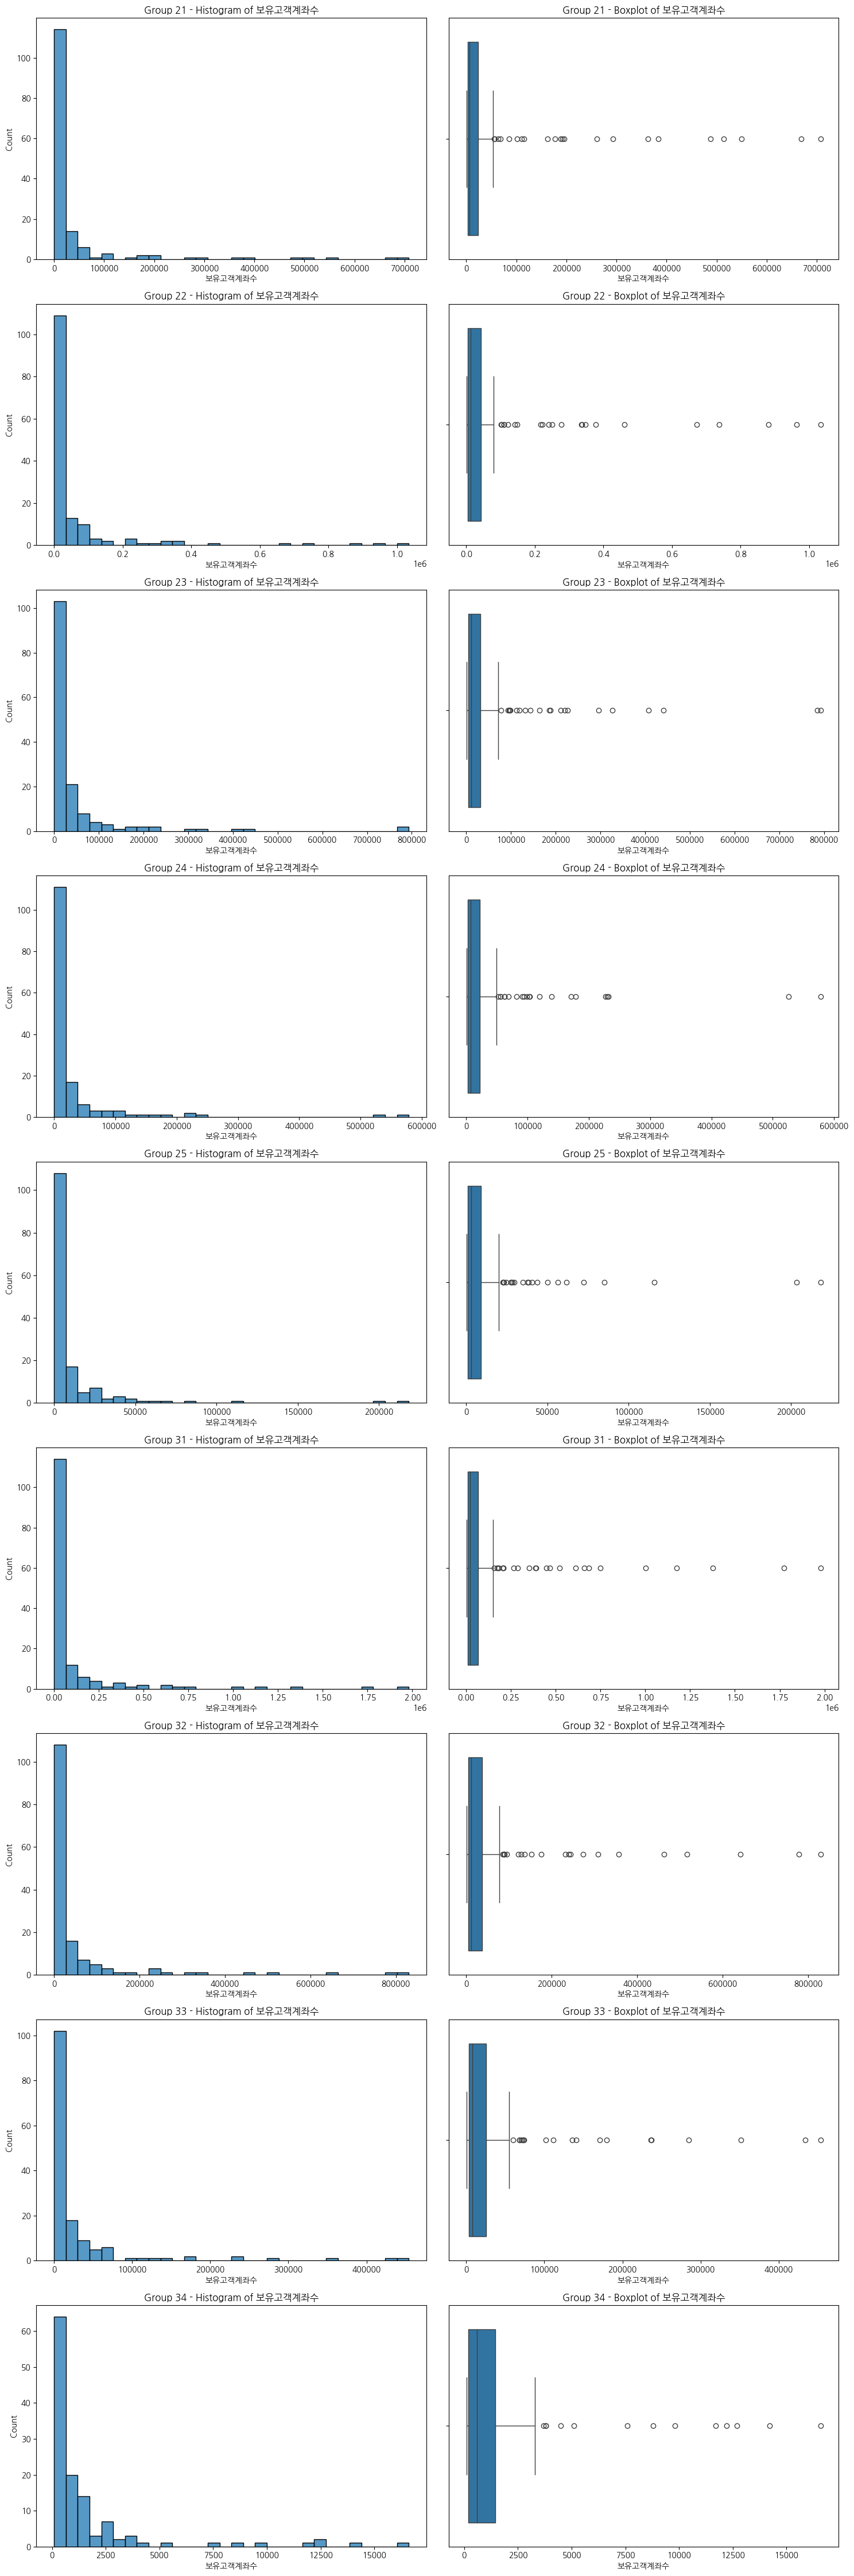

In [36]:
# 한글 폰트 설정
plt.rc('font', family='NanumGothic')
# 히스토그램과 박스플롯을 그리기 위한 설정
fig, axes = plt.subplots(len(dict_0726), 2, figsize=(15, 5 * len(dict_0726)))

for i, (group_name, df) in enumerate(dict_0726.items()):
    # 히스토그램
    sns.histplot(df['보유고객계좌수'], bins=30, ax=axes[i, 0])
    axes[i, 0].set_title(f'Group {group_name} - Histogram of 보유고객계좌수')
    
    # 박스플롯
    sns.boxplot(x=df['보유고객계좌수'], ax=axes[i, 1])
    axes[i, 1].set_title(f'Group {group_name} - Boxplot of 보유고객계좌수')

plt.tight_layout()
plt.show()

In [37]:
# dict_0726의 각 value의 보유고객계좌수가 가장 높은 10개의 ETF를 찾아 출력
for group_name in group_names:
    imsi = dict_0726[group_name]
    top_10_etfs = imsi.sort_values(by='보유고객계좌수', ascending=False).head(10).index
    print(f'{group_name}:{list(top_10_etfs)}')

21:['TQQQ', 'QQQ', 'SOXL', 'SCHD', 'SPY', 'VOO', 'SPLG', 'QLD', 'TMF', 'TLT']
22:['TQQQ', 'QQQ', 'SOXL', 'SCHD', 'SPY', 'VOO', 'TMF', 'QLD', 'SPLG', 'TLT']
23:['SOXL', 'TQQQ', 'SCHD', 'QQQ', 'TMF', 'SPY', 'TSLL', 'JEPI', 'TLT', 'VOO']
24:['SOXL', 'TQQQ', 'QQQ', 'SCHD', 'TMF', 'TSLL', 'SPY', 'JEPI', 'TLT', 'QLD']
25:['SOXL', 'TQQQ', 'QQQ', 'SPY', 'TMF', 'SCHD', 'TSLL', 'TLT', 'JEPI', 'VOO']
31:['TQQQ', 'SOXL', 'QQQ', 'SCHD', 'SPY', 'SPLG', 'VOO', 'TMF', 'QLD', 'TSLL']
32:['TQQQ', 'SOXL', 'QQQ', 'SCHD', 'SPY', 'TMF', 'VOO', 'TLT', 'TSLL', 'QLD']
33:['SOXL', 'TQQQ', 'QQQ', 'SCHD', 'SPY', 'TMF', 'TLT', 'VOO', 'JEPI', 'TSLL']
34:['QQQ', 'SOXL', 'TMF', 'TQQQ', 'SPY', 'TLT', 'SCHD', 'VOO', 'SOXX', 'JEPI']


In [38]:
# dict_0726의 각 value의 '보유고객계좌수'가 Q3 보다 큰 index를 찾아 딕셔너리 형태로 저장
dict_0726_q3 = {key: value[value['보유고객계좌수'] > value['보유고객계좌수'].quantile(0.75)].index.tolist() for key, value in dict_0726.items()}

# value값들의 길이를 출력
for group_name in group_names:
    print(f'{group_name}: {len(dict_0726_q3[group_name])}')

# 리스트의 원소별로 몇개의 그룹에 속하는지 확인하여 출력
from collections import Counter
count = Counter([etf for etfs in dict_0726_q3.values() for etf in etfs])
print(len(count))
print(count)


21: 38
22: 38
23: 38
24: 38
25: 38
31: 38
32: 38
33: 38
34: 31
47
Counter({'ARKG': 9, 'ICLN': 9, 'JEPI': 9, 'JEPQ': 9, 'NVDL': 9, 'SOXL': 9, 'SOXX': 9, 'SPY': 9, 'TLT': 9, 'TQQQ': 9, 'TSLL': 9, 'UPRO': 9, 'ARKK': 9, 'LIT': 9, 'METV': 9, 'QLD': 9, 'QQQ': 9, 'QQQM': 9, 'SCHD': 9, 'TMF': 9, 'TSLY': 9, 'VOO': 9, 'YINN': 9, 'IVV': 8, 'TLTW': 8, 'CONY': 8, 'QYLD': 8, 'SPLG': 8, 'SPYG': 8, 'LABU': 8, 'VNQ': 7, 'SMH': 7, 'SSO': 7, 'DIA': 6, 'NVDY': 6, 'VTI': 6, 'BOTZ': 6, 'USD': 5, 'SPHD': 4, 'CWEB': 3, 'CONL': 3, 'TNA': 3, 'IWM': 3, 'SPYD': 2, 'VIG': 2, 'ARKX': 1, 'MOAT': 1})
